# Read realtime data from IOOS Sensor Map via ERDDAP tabledap

Exploring use of Python to formulate requests to the [`ERDDAP` `tabledap`](http://coastwatch.pfeg.noaa.gov/erddap/index.html) service from [IOOS Sensor Map](https://sensors.ioos.us/#map) data requests and process the various responses available.

`ERDDAP` [RESTful Web Services](http://coastwatch.pfeg.noaa.gov/erddap/rest.html) can be accessed via the [Data Access Form](http://erddap.axiomdatascience.com/erddap/tabledap/sensor_service.html)
 or we can construct then endpoint with a simple `Python` function like the one below.

In [1]:
import requests
from urllib.parse import urlencode


def encode_erddap(urlbase, fname, columns, params):
    """
    urlbase: the base string for the endpoint. For example: `http://erddap.axiomdatascience.com/erddap/tabledap`.
    fname: the data source (e.g.: `sensor_service`) and the response (e.g.: `.csvp` for CSV).
    columns: the columns of the return table.
    params: the parameters for the query.
    
    Returns a valid ERDDAP endpoint.
    """
    urlbase = urlbase.rstrip('/')
    if not urlbase.lower().startswith(('http:', 'https:')):
        msg = 'Expected valid URL but got {}'.format
        raise ValueError(msg(urlbase))

    columns = ','.join(columns)
    params = urlencode(params)
    endpoint = '{urlbase}/{fname}?{columns}&{params}'.format

    url = endpoint(urlbase=urlbase, fname=fname,
                   columns=columns, params=params)
    r = requests.get(url)
    r.raise_for_status()
    return url

We want to bypass the forms and get the data by generating the URL "by hand" using the function we defined above. Below we have a query for `Significant Wave Height` from buoy `44011` starting at the begining of the year 2017.

Please check the [documentation](http://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html) for more information on the various parameters and responses of ERDDAP.

In [2]:
from urllib.parse import unquote


urlbase = 'http://erddap.axiomdatascience.com/erddap/tabledap'

fname = 'sensor_service.csvp'

columns = ('time',
           'value',
           'station',
           'longitude',
           'latitude',
           'parameter',
           'unit',
           'depth')
params = {
    # Inequalities do not exist in HTTP parameters,
    # so we need to hardcoded the `>` in the time key to get a '>='.
    # Note that a '>' or '<' cannot be encoded with `urlencode`, only `>=` and `<=`.
    'time>': '2017-01-00T00:00:00Z',
    'station': '"urn:ioos:station:wmo:44011"',
    'parameter': '"Significant Wave Height"',
    'unit': '"m"',
}

url = encode_erddap(urlbase, fname, columns, params)

print(unquote(url))

http://erddap.axiomdatascience.com/erddap/tabledap/sensor_service.csvp?time,value,station,longitude,latitude,parameter,unit,depth&time>=2017-01-00T00:00:00Z&station="urn:ioos:station:wmo:44011"&parameter="Significant+Wave+Height"&unit="m"


The data `tabledap` `csvp` response can be easily read by pandas `read_csv`.

In [3]:
from pandas import read_csv

df = read_csv(url, index_col=0, parse_dates=True)

df.head()

,value,station,longitude (degrees_east),latitude (degrees_north),parameter,unit,depth (m)
time (UTC),,,,,,,
2017-03-22 15:00:00,1.1,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-22 14:50:00,1.1,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-22 14:00:00,1.1,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-22 13:50:00,1.1,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-22 13:00:00,1.1,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0


With the `DataFrame` we can easily plot the data.

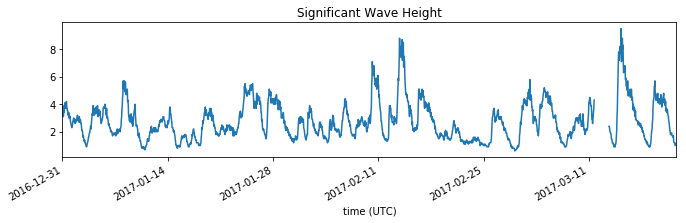

In [4]:
%matplotlib inline

ax = df['value'].plot(figsize=(11, 2.75), title=df['parameter'][0])

Note that slicing the time dimension on the sever side is very fast when compared with an OPeNDAP request, download of the time dimension data, slice, and subsequent download of the actual data.

`ERDDAP` also allows filtering the values of the variable. Let's get Wave Heights that are bigger than 6 meters for example starting from `2016`.

PS: note how we can lazily build on top of the previous query using Python's dictionaries.

In [5]:
params.update(
    {
        'value>': 6,
        'time>': '2016-01-00T00:00:00Z',
    }
)

url = encode_erddap(urlbase, fname, columns, params)

df = read_csv(url, index_col=0, parse_dates=True)

df.head()

,value,station,longitude (degrees_east),latitude (degrees_north),parameter,unit,depth (m)
time (UTC),,,,,,,
2017-03-15 20:00:00,6.4,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 19:50:00,6.4,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 19:00:00,6.8,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 18:50:00,6.8,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 18:00:00,6.4,urn:ioos:station:wmo:44011,-66.619,41.098,Significant Wave Height,m,0.0


And now we can visualize the frequency of `Significant Wave Height` greater than 6 meters by month.

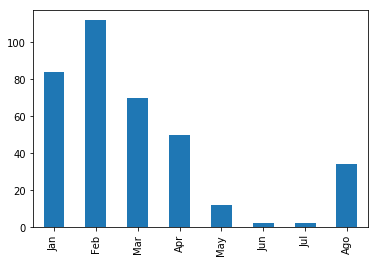

In [6]:
key = lambda x: x.month

grouped = df['value'].groupby(key)

ax = grouped.count().plot.bar()
m = ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])

There is also a built-in relative time functionality.
Here we demonstrate that by getting the last 2 hours and displaying that with the HTML response in an `IFrame`.

In [7]:
from IPython.display import HTML


fname = 'sensor_service.htmlTable'

params = {
    'time>': 'now-2hours',
    'time<': 'now',
    'station': '"urn:ioos:station:nerrs:wqbchmet"',
    'parameter': '"Wind Speed"',
    'unit': '"m.s-1"'
}

url = encode_erddap(urlbase, fname, columns, params)

HTML('<iframe src={src} width=650 height=370></iframe>'.format(src=url))

`ERDDAP` responses are very rich.
There is even multiple image formats in the graph.
Here is how to get a `png` for the temperature time-series with an arbitrary width/height.

In [8]:
fname = 'sensor_service.png'

params = {
    'time>': 'now-7days',
    'station': '"urn:ioos:station:wmo:44011"',
    'parameter': '"Water Temperature"',
    'unit': '"degree_Celsius"',
}


width, height = 450, 500
params.update(
    {'.size': '{}|{}'.format(width, height)}
)

url = encode_erddap(urlbase, fname, columns, params)

HTML('<iframe src={src} width={width} height={height}></iframe>'.format(src=url, width=width+5, height=height+5))

Explore more datasets using the sensor map [website](https://sensors.ioos.us/#map)!

<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map.ipynb)
this notebook, or see a static view [here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map.ipynb).